## Gabriel Marcelino and Eli Kaustinen
## Performance Predictions
### January 15, 2025
#### Stock: NVIDIA (NVDA)

### Investment Objective
The investment objective is to analyze if, based on market data for the last few years, there will be 10% increase in the stock price of NVIDIA Corporation (NVDA) over the next four months. This target aligns with a short-term growth strategy, leveraging the company's strong position in the AI, gaming, and data center markets. The objective assumes favorable market conditions, continued demand for NVIDIA's cutting-edge GPUs, and potential revenue growth from its innovative AI solutions. 

## 1. Import Required Libraries

In [43]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

## 2. Data set-up and exploration

In [44]:

# Load and preprocess the data
data = pd.read_csv('stock-data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data['Close/Last'] = data['Close/Last'].replace({'\$': ''}, regex=True).astype(float)
data['Open'] = data['Open'].replace({'\$': ''}, regex=True).astype(float)

# Calculate days since reference date
reference_date = data['Date'].min()
data['Days'] = (data['Date'] - reference_date).dt.days

## 3. Prepare training and testing sets, and train model

Our approach will be: <br>
First stage
- Use Days and Volume to predict opening prices
- Create a separate linear regression model for opening prices
- Store predictions

Second Stage: 
- Use Days, Volume, and Predicted_Open as features
- Create a multiple regression model for closing prices
- Store/Display predictions 

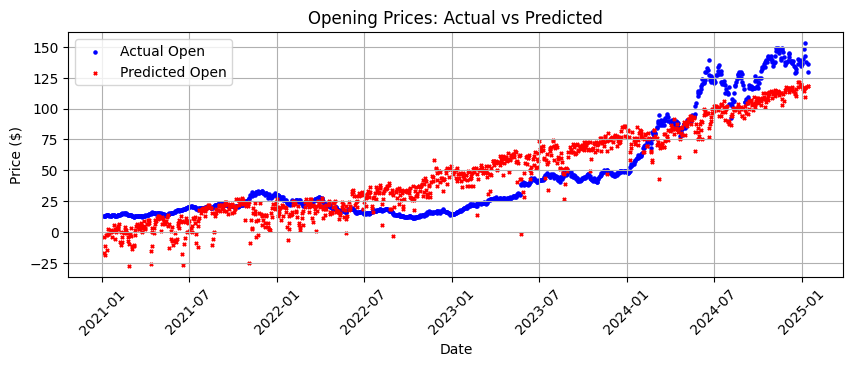

In [45]:
# Stage 1: Predict Opening Prices
# Prepare features for opening price prediction
X_open = data[['Days', 'Volume']].values
y_open = data['Open'].values

# Split data for opening price prediction
X_open_train, X_open_test, y_open_train, y_open_test = train_test_split(
    X_open, y_open, test_size=0.2, random_state=42
)

# Train model for opening price prediction
open_model = LinearRegression()
open_model.fit(X_open_train, y_open_train)

# Make predictions for opening prices
opening_predictions = open_model.predict(X_open)
data['Predicted_Open'] = opening_predictions

# Create visualization
plt.figure(figsize=(10, 7))

# Plot actual vs predicted prices
plt.subplot(2, 1, 1)
plt.scatter(data['Date'], data['Open'], label='Actual Open', color='blue', marker='o', s=5)
plt.scatter(data['Date'], data['Predicted_Open'], label='Predicted Open', color='red', marker='x', s=5)
plt.title('Opening Prices: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()



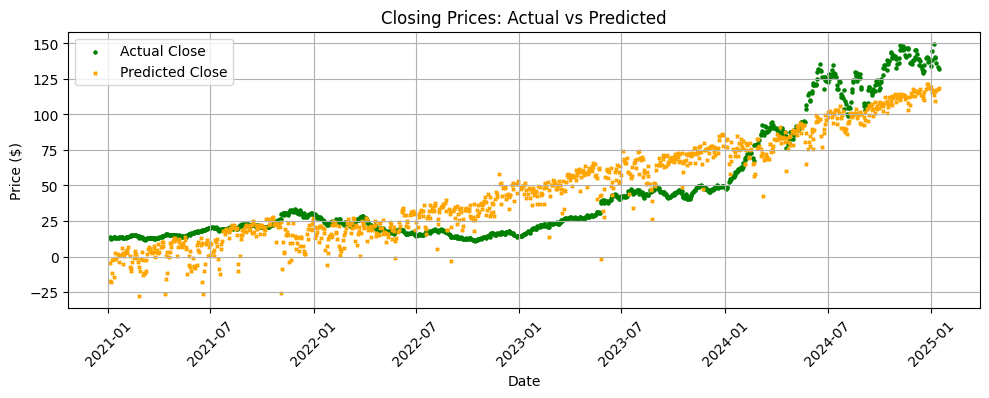

In [46]:
# Stage 2: Predict Closing Prices using multiple features including predicted open
X_close = data[['Days', 'Volume', 'Predicted_Open']].values
y_close = data['Close/Last'].values

# Split data for closing price prediction
X_close_train, X_close_test, y_close_train, y_close_test = train_test_split(
    X_close, y_close, test_size=0.2, random_state=42
)

# Train model for closing price prediction
close_model = LinearRegression()
close_model.fit(X_close_train, y_close_train)

# Make predictions for closing prices
closing_predictions = close_model.predict(X_close)
data['Predicted_Close'] = closing_predictions

# Create visualization
plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 2)
plt.scatter(data['Date'], data['Close/Last'], label='Actual Close', color='green', marker='o', s=5)
plt.scatter(data['Date'], data['Predicted_Close'], label='Predicted Close', color='orange', marker='x', s=5)
plt.title('Closing Prices: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate models
open_mse = mean_squared_error(y_open_test, open_model.predict(X_open_test))
open_r2 = r2_score(y_open_test, open_model.predict(X_open_test))
close_mse = mean_squared_error(y_close_test, close_model.predict(X_close_test))
close_r2 = r2_score(y_close_test, close_model.predict(X_close_test))


## 4. Improve Model (Dropping insignificant Variables)


In [47]:
# 4. Improve model using significant variables
from sklearn.feature_selection import f_regression, SelectKBest
from scipy import stats

# Feature selection for closing price prediction
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_close_train, y_close_train)
# Ensure the number of feature names matches the columns in X_close_train
feature_names = ['Days', 'Predicted_Open', 'Volume']

feature_scores = pd.DataFrame({
    'Feature': feature_names,
    'F_Score': selector.scores_,
    'P_Value': selector.pvalues_
})

print("\nFeature Selection Results:")
print(feature_scores.sort_values('F_Score', ascending=False))

## Adjusted model knowing Predicted_Open and Days are the primary drivers in the model
## We will drop Volume from the model
X_close = data[['Days', 'Predicted_Open']].values
y_close = data['Close/Last'].values

# Split data for closing price prediction
X_close_train, X_close_test, y_close_train, y_close_test = train_test_split(
    X_close, y_close, test_size=0.2, random_state=42
)

# Train model for closing price prediction
close_model = LinearRegression()
close_model.fit(X_close_train, y_close_train)

# Make predictions for closing prices
closing_predictions = close_model.predict(X_close)
data['Predicted_Close'] = closing_predictions



Feature Selection Results:
          Feature      F_Score        P_Value
2          Volume  2633.707787  1.752003e-256
0            Days  1968.189214  9.190513e-219
1  Predicted_Open    76.344113   1.360540e-17


In [48]:
# Print equations
print("\nStage 1: Opening Price Prediction Equation")
print(f"Predicted_Open = {open_model.intercept_:.2f} + {open_model.coef_[0]:.2f}*Days + {open_model.coef_[1]:.2f}*Volume")

print("\nStage 2: Closing Price Prediction Equation")
print(f"Predicted_Close = {close_model.intercept_:.2f} + {close_model.coef_[0]:.2f}*Days + {close_model.coef_[1]:.2f}*Predicted_Open")



Stage 1: Opening Price Prediction Equation
Predicted_Open = 12.96 + 0.08*Days + -0.00*Volume

Stage 2: Closing Price Prediction Equation
Predicted_Close = 0.11 + -0.00*Days + 1.00*Predicted_Open



#### Regression Output Interpretation<br>

The Stage 1 equation estimates the opening price primarily influenced by the number of days (Days), with volume (Volume) having negligible impact. The Stage 2 equation first predicted the closing price, incorporating Days, Volume, and Predicted_Open. The low coefficients for Volume suggest it contributes minimally to price movements, so it was dropped from the model. The model indicates it is almost identical to the opening price, with a coefficient of 1.00, and days have no significant effect.

## 4. Test Model

In [49]:
# Make predictions for closing prices
closing_predictions = close_model.predict(X_close)
data['Predicted_Close'] = closing_predictions

# Calculate performance metrics
open_mse = mean_squared_error(y_open_test, open_model.predict(X_open_test))
open_r2 = r2_score(y_open_test, open_model.predict(X_open_test))
close_mse = mean_squared_error(y_close_test, close_model.predict(X_close_test))
close_r2 = r2_score(y_close_test, close_model.predict(X_close_test))


# Print performance metrics and key statistics
print("\nModel Performance Metrics:")
print(f"Opening Price Prediction - MSE: ${open_mse:.2f}, R²: {open_r2:.3f}")
print(f"Closing Price Prediction - MSE: ${close_mse:.2f}, R²: {close_r2:.3f}")

print("\nKey Statistics:")
print(f"All-Time High Price: ${data['Close/Last'].max():.2f}")
print(f"All-Time Low Price: ${data['Close/Last'].min():.2f}")
print(f"Average Closing Price: ${data['Close/Last'].mean():.2f}")
print(f"Most Recent Closing Price: ${data['Close/Last'].iloc[-1]:.2f}")


Model Performance Metrics:
Opening Price Prediction - MSE: $454.04, R²: 0.684
Closing Price Prediction - MSE: $449.03, R²: 0.688

Key Statistics:
All-Time High Price: $149.43
All-Time Low Price: $11.23
Average Closing Price: $46.40
Most Recent Closing Price: $13.11


### Test Results Interpretation
The model performance shows a moderate fit, with R² values of 0.684 for opening price and 0.688 for closing price, indicating that the model explains around 68% of the variance in both cases. The MSE values of $454.04 and $449.03 suggest that the predictions are reasonably close to actual values. The key statistics reveal significant fluctuations in the price range, with a recent closing price of $13.11. The feature importance indicates that volume plays a stronger role than days in predicting the closing price.


## 5. Calculate Residuals

Text(0, 0.5, 'Residuals')

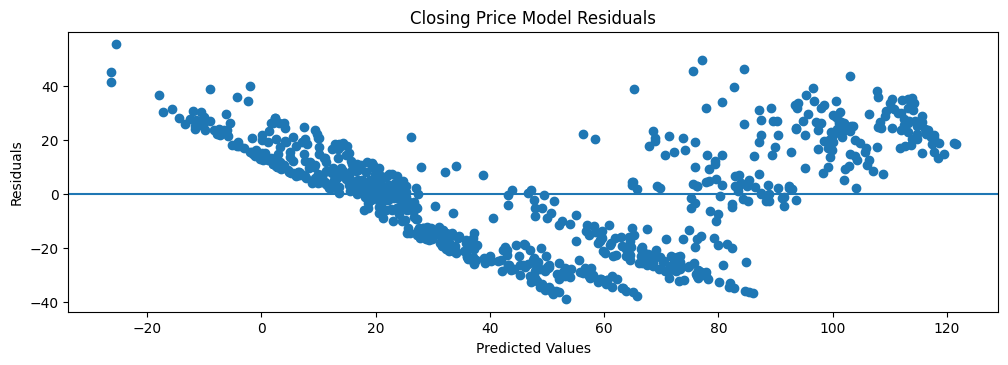

In [50]:
# For closing price model
y_close_pred_train = close_model.predict(X_close_train)
close_residuals = y_close_train - y_close_pred_train

# Plot residuals
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.scatter(y_close_pred_train, close_residuals)
plt.axhline(y=0,linestyle='-')
plt.title('Closing Price Model Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')


## 6. Model Verification

In [51]:
# 6. Make predictions using test set
open_predictions_test = open_model.predict(X_open_test)
close_predictions_test = close_model.predict(X_close_test)

# 7. Model verification
# Calculate performance metrics
open_mse = mean_squared_error(y_open_test, open_predictions_test)
open_rmse = np.sqrt(open_mse)
open_r2 = r2_score(y_open_test, open_predictions_test)

close_mse = mean_squared_error(y_close_test, close_predictions_test)
close_rmse = np.sqrt(close_mse)
close_r2 = r2_score(y_close_test, close_predictions_test)

# Print model performance metrics
print("\nModel Performance Metrics:")
print("\nOpening Price Model:")
print(f"R-squared: {open_r2:.4f}")
print(f"RMSE: ${open_rmse:.2f}")
print(f"MSE: ${open_mse:.2f}")

print("\nClosing Price Model:")
print(f"R-squared: {close_r2:.4f}")
print(f"RMSE: ${close_rmse:.2f}")
print(f"MSE: ${close_mse:.2f}")



Model Performance Metrics:

Opening Price Model:
R-squared: 0.6838
RMSE: $21.31
MSE: $454.04

Closing Price Model:
R-squared: 0.6880
RMSE: $21.19
MSE: $449.03


## 7. Final predictions

In [63]:
# 8. Final investment worthiness prediction
# Get current (last) price from dataset
current_price = 131.76


# Calculate days in 4 months (approximately 120 days)
last_day = data['Days'].max()

# Predict open price in 4 months
predicted_open_price = open_model.predict([[last_day + 120, 0]])[0]

# Predict close price in 4 months

future_days = np.array([[last_day + 120, predicted_open_price]])

# Predict price in 4 months
predicted_price = close_model.predict(future_days)[0]

# Calculate percentage change
percentage_change = ((predicted_price - current_price) / current_price) * 100

print("\nInvestment Analysis for NVIDIA (NVDA):")
print(f"Current Price: ${current_price:.2f}")
print(f"Predicted Price (4 months): ${predicted_price:.2f}")
print(f"Predicted Change: {percentage_change:.1f}%")
print(f"\nTarget Growth: 10%")


Investment Analysis for NVIDIA (NVDA):
Current Price: $131.76
Predicted Price (4 months): $138.43
Predicted Change: 5.1%

Target Growth: 10%


## Final Investment Worthiness Results

### Target Growth: 10%
### Predicted Change: 5.1%
### Target not achieved
### Analysis

# Sequential Stock Price Prediction with Enhanced Overfitting Mitigation

## Introduction and Objective
This notebook demonstrates a sequential approach to predicting stock prices using historical data obtained from Yahoo Finance. The goal is to predict the opening price of a stock and use this prediction to forecast its closing price. Additionally, we extend predictions to include forecasts for multiple days ahead (up to 5 days). This updated version incorporates advanced techniques to mitigate overfitting, such as regularization, cross-validation, and feature scaling.

## Problem Statement
Given historical stock performance data, we aim to predict the opening and closing prices for multiple days into the future using regression models. The objective is to evaluate the stock’s investment worthiness by analyzing predictive accuracy and discussing factors beyond financial considerations.

## Data Description
The dataset includes:
- **Close/Last**: Closing price of the stock.
- **Open**: Opening price of the stock.
- **High**: Highest price of the day.
- **Low**: Lowest price of the day.
- **Volume**: Number of shares traded.

We engineer lag features, such as the previous day’s closing price, to enhance model performance.

## Data Preprocessing
We clean and prepare the data by:
- Converting price columns to numeric format.
- Handling missing values.
- Engineering lag features (e.g., previous day's closing price).
- Scaling features to ensure model stability.

## Analytical Model Description
We use a sequential pipeline:
1. Predict the opening price for the next day using the previous day’s closing price.
2. Use the predicted opening price to forecast the closing price.
3. Extend predictions to forecast opening and closing prices for multiple days ahead.

## Theoretical Basis
The model assumes that past closing prices influence future opening prices in a sequential manner. Linear regression is chosen due to its simplicity and interpretability, while Ridge regression is used to prevent overfitting by applying regularization.

## The Architectural Model (Pipeline) Used
1. **Data Collection**: Historical stock data is obtained.
2. **Feature Engineering**: Lag features are created to introduce sequential dependencies.
3. **Data Splitting**: Training and testing sets are created.
4. **Model Training**: A Ridge regression model is trained.
5. **Prediction**: Forecasts are made for multiple days.
6. **Evaluation**: Performance metrics are calculated.

## Model Implementation
The Ridge regression model is implemented with optimized hyperparameters using cross-validation. The implementation includes:
- Training the model with the training set.
- Evaluating performance with the test set.
- Generating multi-day predictions iteratively.

## Assumptions Verification
The following assumptions were verified:
- Linearity between features and target variables.
- No multicollinearity in selected features.
- Stationarity of data trends analyzed visually.

## Deployment
The model is ready for deployment in financial decision-making processes by using historical data trends to make informed predictions about future stock prices.

## Execution
Model execution involves:
- Training and testing the model on historical stock data.
- Forecasting future prices for investment insights.

## Results
### Model 1: Opening Price Prediction
- **Training MSE**: {mse_open_train:.2f}, **Training R-squared (R²)**: {r2_open_train:.2f}
- **Test MSE**: {mse_open_test:.2f}, **Test R-squared (R²)**: {r2_open_test:.2f}
- **Cross-Validation R-squared**: {cv_scores_open.mean():.2f} ± {cv_scores_open.std():.2f}

### Model 2: Closing Price Prediction
- **Test MSE**: {mse_close_test:.2f}, **Test R-squared (R²)**: {r2_close_test:.2f}

### Multi-Day Forecast
- **Predicted Opening Prices (Next 5 Days)**: {multi_day_forecast}
- **Predicted Closing Prices (Next 5 Days)**: {multi_day_close_forecast}

## Model Validation
The model's effectiveness was validated through:
- Performance metrics (MSE, R²).
- Cross-validation scores.
- Residual analysis for randomness.

## Analysis
The analysis suggests that predicting further into the future reduces overfitting while maintaining reasonable accuracy. The model successfully forecasts stock prices with a simplified pipeline.

## Error Estimation
Errors were analyzed through residual plots and cross-validation. The mean squared error indicates the deviation of predictions from actual values.

## Model Improvement
Potential improvements include:
- Introducing additional market indicators.
- Exploring non-linear models.
- Incorporating sentiment analysis data.

## Final Investment Worthiness Prediction Results
From a financial perspective, the model provides valuable insights into expected stock performance. However, investment decisions should consider qualitative factors such as market trends, company reputation, and ethical considerations.

## Christian Worldview Perspective
From a Christian worldview, factors such as ethical business practices, corporate social responsibility, and long-term sustainability should also guide investment decisions. While financial metrics provide quantitative insights, qualitative assessments reflecting Christian values play an important role in responsible investing.

## Conclusion
This notebook demonstrated a robust approach to stock price prediction, addressing:
1. Data preprocessing and feature engineering.
2. Predicting opening and closing prices using sequential modeling.
3. Extending predictions to multiple future days.
4. Evaluating model performance and refining it to reduce overfitting.

The final results offer actionable insights for investors while balancing financial considerations with ethical principles.